## Clonal Specificity in TYK2 Chunk 10

We have two clones, named `c1` and `c8`, containing the same TYK2 DMS library and assayed under identical conditions. We can handle this structure in two ways, either by analyzing the clones separately and comparing them post-hoc, or by combining them to increase our barcode coverage and overall power.

1. [Summary](#part1)
2. [Comparisons Between Clones](#part2)
3. [Impact of Clone Aggregation](#part3)

### Summary <a name="part1"></a>

-  The mutation effects quantified in both clones are strongly correlated, and there are no significant differences between clones when tested directly (lowest unadjusted p-value = 0.022, lowest adjusted p-value = 0.95).
-  More significant variants are identified in clone 1, likely due to the higher average number of barcodes per variant.
-  However, stop codons (and strong LoF in general) have a slightly larger effect size in clone 8 compared to clone 1.
-  When clones are combined, we observe a substantial reduction in standard errors and broadly consistent effect sizes or fold changes.
-  Combining clones increases the number of significant variants to 365, from 308 in clone 1 and 251 in clone 8 individually.


### Comparisons Between Clones <a name="part2"></a>

Since we already have summary statistics for each clone individually, the easiest starting point is to just compare the resulting fold changes and standard errors between the two clones at each variant. In the plot below, variants which are nominally significant or non-significant in both clones (unadjusted p-value <= 0.05) are colored red and purple, respectively. The other two colors indicate clones which are nominally significant in only one clone or the other but not both.

In [2]:
library(ggpubr)
library(scico)
library(scales)
library(patchwork)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

In [3]:
sumstats <- read_tsv("../sumstats/10-combined.sumstats.tsv") %>%
    separate(term, c("condition","aa"), sep = ":") %>%
    mutate(condition = gsub("condition", "", condition))

sumstats_contr <- sumstats %>%
    select(-statistic, -p.value) %>%
    group_by(pos, clone, chunk, aa) %>%
    pivot_wider(names_from = condition, values_from = c(estimate, std.error)) %>%
    summarize(estimate = estimate_IFNa2a - estimate_none,
              std.error = sqrt((std.error_IFNa2a^2)+(std.error_none^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos,clone,chunk,aa,estimate,std.error,statistic,p.value) %>%
    ungroup() %>%
    mutate(fdr = p.adjust(p.value,method = "BH"))

sumstats_clone_contr <- sumstats_contr %>%
    select(-statistic, -p.value, -fdr) %>%
    group_by(pos, chunk, aa) %>%
    pivot_wider(names_from = clone, values_from = c(estimate, std.error)) %>%
    summarize(estimate = estimate_c1 - estimate_c8,
              std.error = sqrt((std.error_c1^2)+(std.error_c8^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos,chunk,aa,estimate,std.error,statistic,p.value) %>%
    ungroup() %>%
    mutate(fdr = p.adjust(p.value,method = "BH"))

Rows: 5600 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): clone, term
dbl (6): pos, chunk, estimate, std.error, statistic, p.value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'pos', 'clone', 'chunk'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'pos', 'chunk'. You can override using the
`.groups` argument.


In [4]:
c1 <- sumstats_contr %>% filter(clone == "c1")
c8 <- sumstats_contr %>% filter(clone == "c8")
clone_compare <- inner_join(c1, c8, by = c("pos","chunk","aa")) %>%
    mutate(uncorrected_significance = case_when(p.value.x <= 0.05 & p.value.y <= 0.05 ~ "both",
                           p.value.x <= 0.05 & p.value.y > 0.05 ~ "clone1",
                           p.value.x > 0.05 & p.value.y <= 0.05 ~ "clone8",
                           TRUE ~ "neither"))

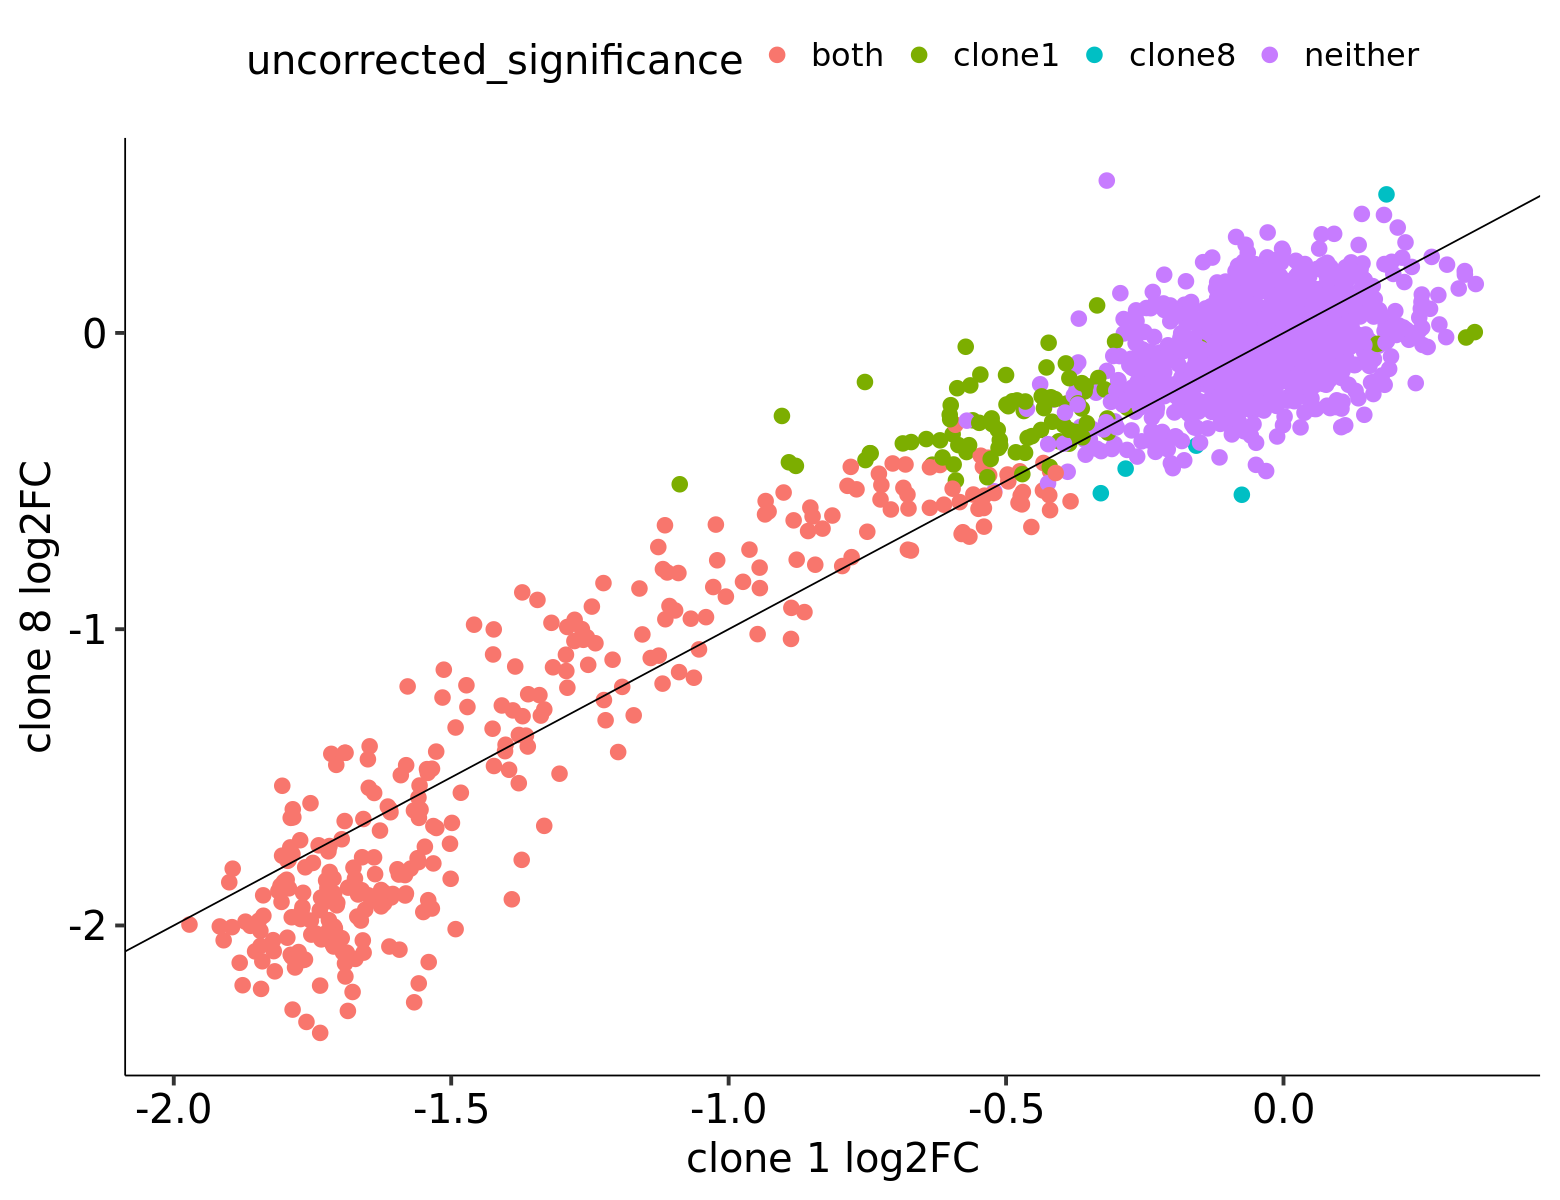

In [5]:
options(repr.plot.width = 13, repr.plot.height = 10)
clone_compare %>%
    ggplot() +
        geom_point(aes(x = estimate.x/log(2), y = estimate.y/log(2), color = uncorrected_significance),  size = 4) +
        theme_pubr(base_size = 24) +
        xlab("clone 1 log2FC") + ylab("clone 8 log2FC") +
        geom_abline(intercept = 0, slope = 1)

Clearly the effect sizes between clones correlate very well, although not completely linearly. Stop effects seem slightly stronger in clone 8 compared to clone 1, but the higher number of barcodes in clone 1 results in a larger number of clone1-only nominally significant variants compared to clone8-only.

We can also actually test whether the `clone1 - clone8` difference in variant effect is significantly different from zero for each variant. We apply a linear contrast analogous to previous comparisons and obtain summary statistics which we can compare with the originals. After correcting for multiple testing, none of the `clone1 - clone8` tests is close to significant (lowest unadjusted p-value = 0.026, lowest adjusted p-value = 0.95). In particular, the p-value histogram summarizes the overall result nicely and "looks", statistically speaking, like a complete absence of signal in the clone difference:

In [6]:
phist1 <- ggplot(sumstats_contr) +
    geom_histogram(aes(x = p.value), bins = 100) +
    theme_pubr(base_size = 20) +
    xlab("Unadjusted p-value") + ylab("Number of Variants") +
    facet_wrap(~clone, ncol = 1) +
    ggtitle("Significance of Variant Effects From Each Clone")

phist2 <- ggplot(sumstats_clone_contr) +
    geom_histogram(aes(x = p.value), bins = 100) +
    theme_pubr(base_size = 20) +
    xlab("Unadjusted p-value") + ylab("Number of Variants") +
    ggtitle("Significance of c1 - c8 Difference")

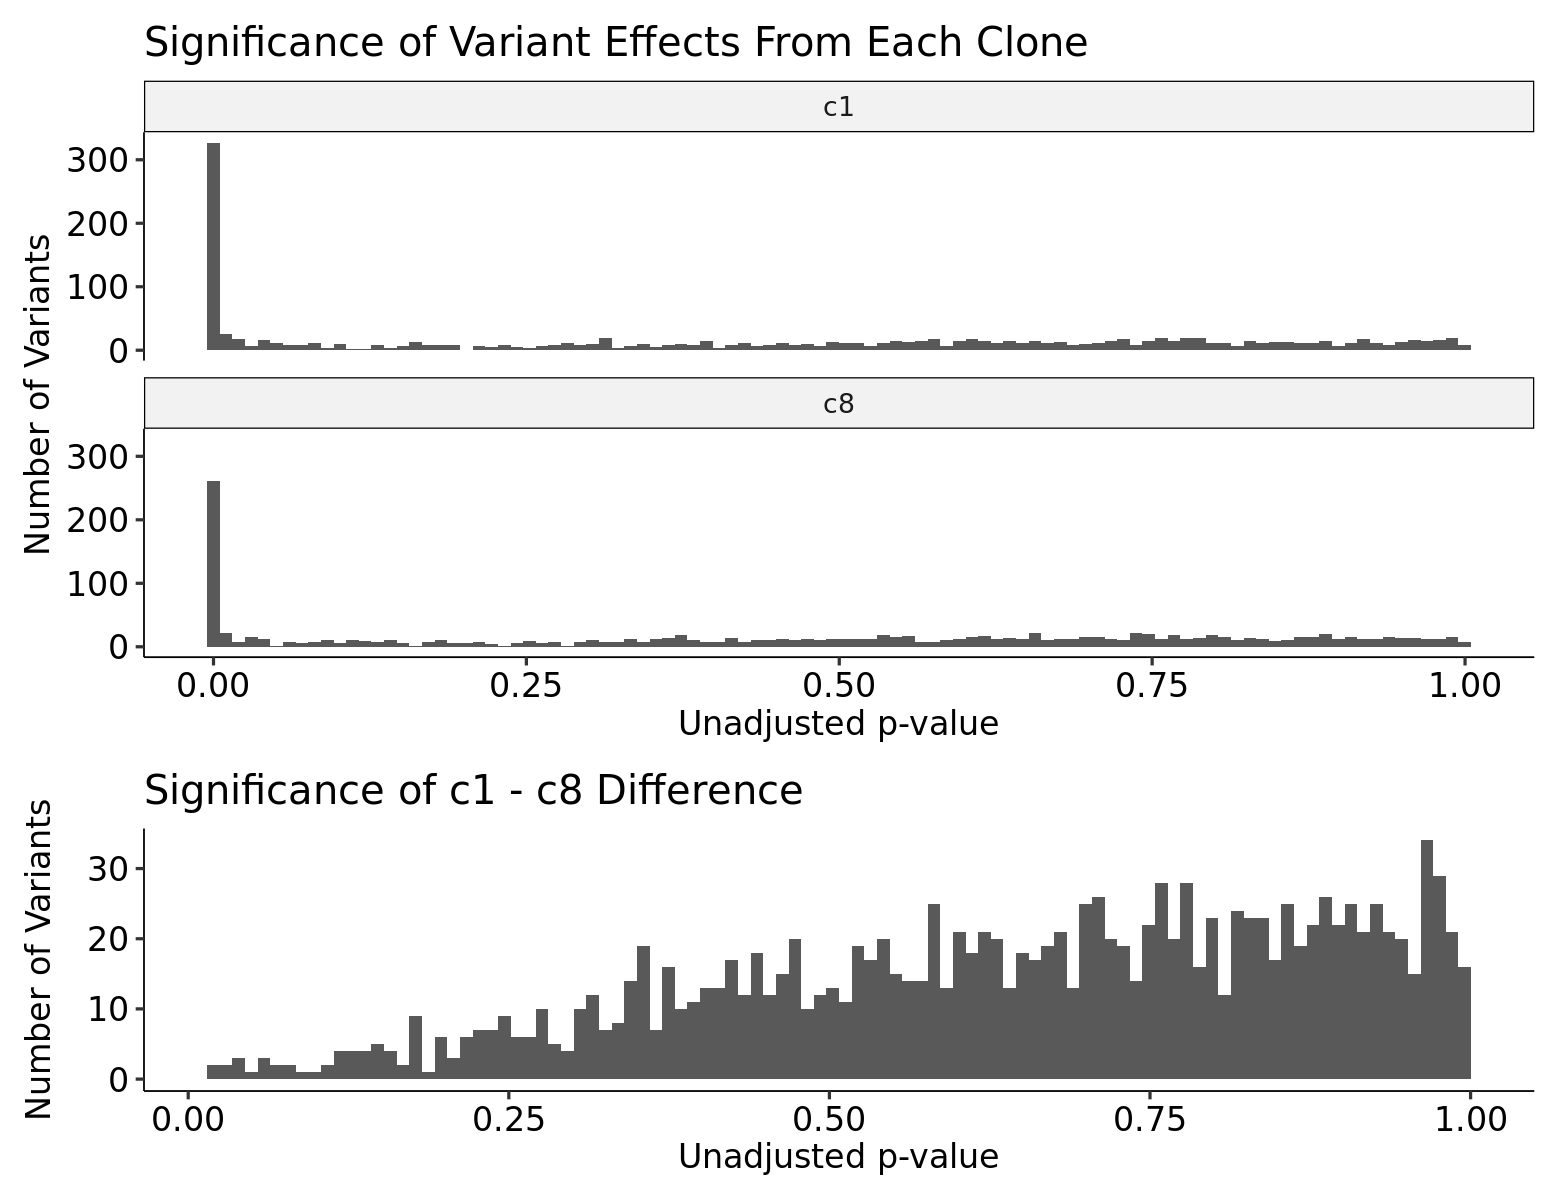

In [7]:
phist1 / phist2 + plot_layout(heights = c(0.66,0.33))

So, while we can gain something from combining clones and their barcodes, there is no statistically significant difference in variant effect profiles between them.

### Impact of Clone Aggregation <a name="part3"></a>

While we will typically have a single clone per chunk, the existence of two allows us to ask how our discovery set would change if the clones were combined. If the clones are highly consistent (i.e. capturing the same effects), we should observe a decrease in standard error leading to higher power and more significant variants identified. If they are not very consistent, we would expect to observe the opposite. We see a fairly large shift of all stop variants to become more negative, due to the expected decrease in standard errors:

In [8]:
sumstats_agg <- read_tsv("../sumstats/10-clonal.sumstats.tsv") %>%
    separate(term, c("condition","aa"), sep = ":") %>%
    mutate(condition = gsub("condition", "", condition),
           aa = gsub("mut_aa", "", aa))

sumstats_agg_contr <- sumstats_agg %>%
    select(-statistic, -p.value) %>%
    group_by(pos, chunk, aa) %>%
    pivot_wider(names_from = condition, values_from = c(estimate, std.error)) %>%
    summarize(estimate = estimate_IFNa2a - estimate_none,
              std.error = sqrt((std.error_IFNa2a^2)+(std.error_none^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos,chunk,aa,estimate,std.error,statistic,p.value) %>%
    ungroup() %>%
    mutate(fdr = p.adjust(p.value,method = "BH"))

Rows: 2800 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): term, version
dbl (6): pos, chunk, estimate, std.error, statistic, p.value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'pos', 'chunk'. You can override using the
`.groups` argument.


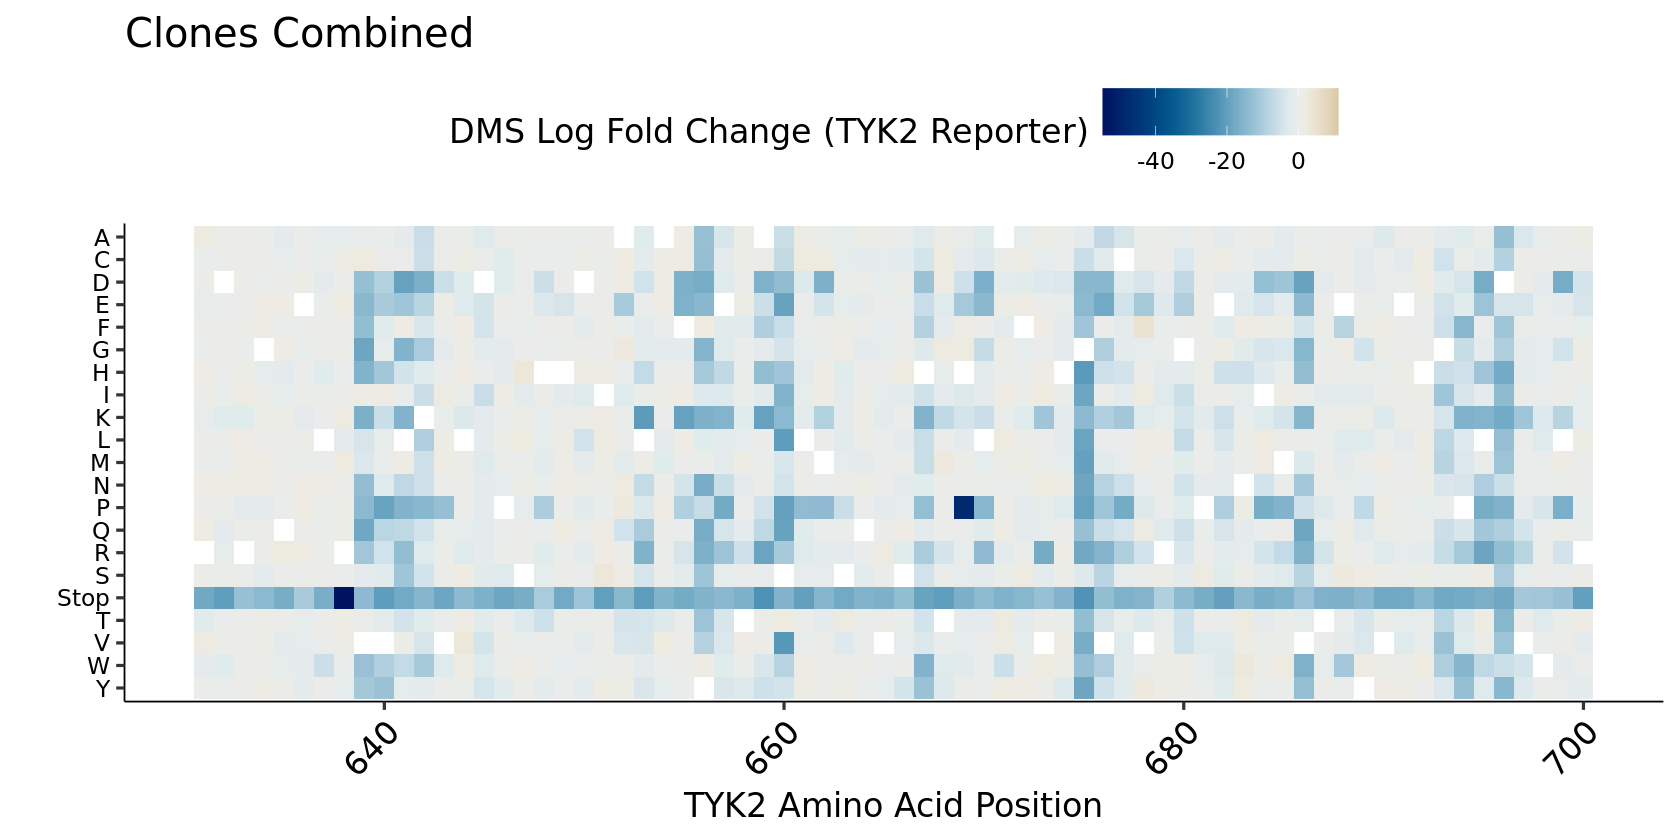

In [9]:
options(repr.plot.height = 7, repr.plot.width = 14)
ggplot(sumstats_agg %>% 
           mutate(aa = if_else(aa == "*", "Stop", aa)) %>%
           #mutate(aa = factor(aa, levels = aalevels)) %>%
           rename("DMS Log Fold Change (TYK2 Reporter)" = statistic)) +
        geom_tile(aes(x = pos, y = fct_rev(aa), fill = `DMS Log Fold Change (TYK2 Reporter)`)) +
        scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        theme(legend.text=element_text(size=14),
              legend.key.size = unit(1,"cm"),
              axis.text.y = element_text(size = 14)) +
        ylab("") + xlab("TYK2 Amino Acid Position") +
        ggtitle("Clones Combined")

Because of the relative scaling, the heatmap looks fairly similar to those we have already seen, except that the scale extends much further negative to about -50. However, comparing the stop variant distributions highlights the power increase:

In [294]:
stop_dist_1 <- sumstats_contr %>%
    mutate(group = if_else(aa == "mut_aa*", "Stop", "Nonstop")) %>%
    ggplot() + 
        geom_density(aes(x = statistic, fill = group, color = group), alpha = 0.6) +
        theme_pubr(base_size = 20) +
        scale_fill_manual(values = c("Stop" = "red", "Nonstop" = "grey")) + 
        scale_color_manual(values = c("Stop" = "red", "Nonstop" = "grey")) +
        ggtitle("Clones Separated") +
        facet_wrap(~clone, ncol = 1) + xlim(c(-50,5))

stop_dist_2 <- sumstats_agg_contr %>%
    mutate(group = if_else(aa == "*", "Stop", "Nonstop")) %>%
    ggplot() + 
        geom_density(aes(x = statistic, fill = group, color = group), alpha = 0.6) +
        theme_pubr(base_size = 20) +
        scale_fill_manual(values = c("Stop" = "red", "Nonstop" = "grey")) + 
        scale_color_manual(values = c("Stop" = "red", "Nonstop" = "grey")) +
        ggtitle("Clones Combined") + xlim(c(-50,5))

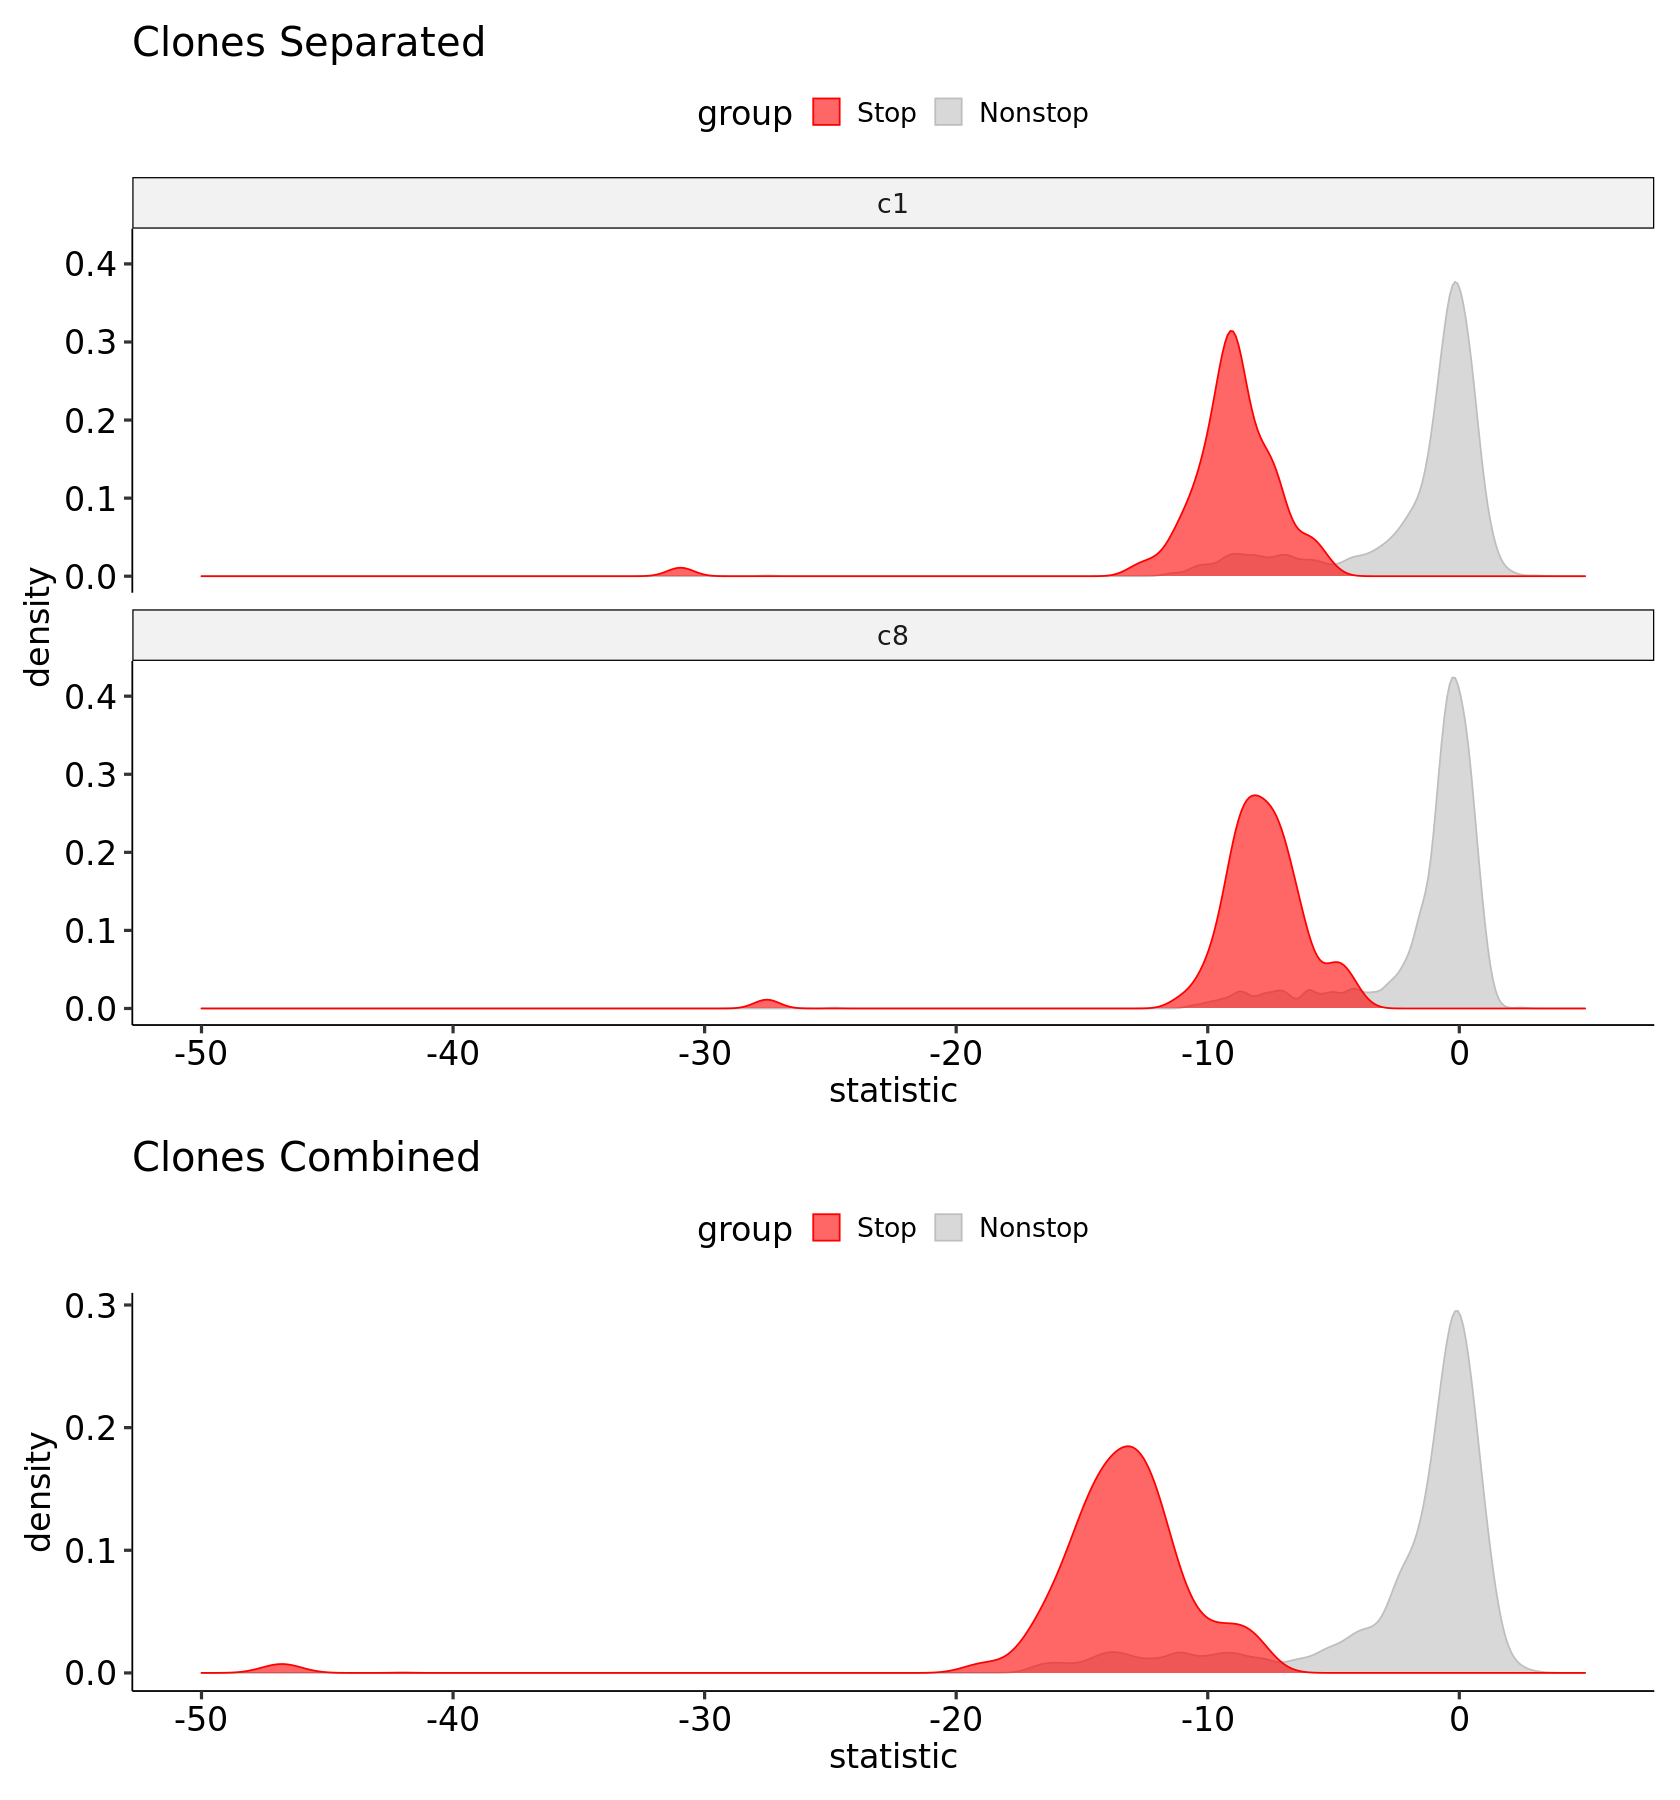

In [295]:
options(repr.plot.height = 15, repr.plot.width = 14)
stop_dist_1 / stop_dist_2 + plot_layout(heights = c(0.66, 0.33))